# Bird Classification Project
#### Megi Dervishi
The following notebook has 2 main parts:
1. Crop Dataset
2. Method 

Section 1 pre-processes the bird dataset and crops it.
If one has already created the cropped datasets ("cropped_bird_dataset_no_square" or "cropped_bird_dataset") already you can start the notebook at section 2 (Method).

# Crop Dataset

## 1. Library and Data Installation

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


torch:  1.9 ; cuda:  cpu
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.9/index.html


ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2
You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


In [ ]:
!git clone --branch v0.6 https://github.com/facebookresearch/detectron2.git detectron2_repo
# install detectron2 from source
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13559, done.
remote: Counting objects: 100% (1060/1060), done.
remote: Compressing objects: 100% (563/563), done.
remote: Total 13559 (delta 657), reused 819 (delta 488), pack-reused 12499
Receiving objects: 100% (13559/13559), 5.80 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (9613/9613), done.
Note: checking out 'd1e04565d3bec8719335b88be9e9b961bf3ec464'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Obtaining file:///content/detectron2_repo
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6+cu111
    Uninstalling detectron2-0.6+cu111:


In [ ]:
#!!Restart runtime
#detectron2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

# PointRend project
from detectron2.projects import point_rend

#images
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

#other
import os, os.path
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

#torch/torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable


In [1]:
#!wget https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
#!unzip /content/bird_dataset.zip
print("Done")

Done


## 2. Detect and crop dataset

In [ ]:
class BirdDetectron2():
  """
  BirdDetectron2 : 
  Dects birds in images using the facebook/research library detectron2
  model_type options: 
    1. instance segmentation with mask_rcnn
    2. instance segmentation with point rending
    3. panoptic segmentation with fpn
  # code based on google colabs from git repository of detectron2
  """
  def __init__(self, model_type = "IS"):
    self.cfg = get_cfg()
    self.model_type = model_type
    if self.model_type == "IS": #instance segmentation with mask rcnn
      self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
      self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
    if self.model_type == "PR": #point rending
      point_rend.add_pointrend_config(self.cfg)
      self.cfg.merge_from_file("detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_X_101_32x8d_FPN_3x_coco.yaml")
      self.cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_X_101_32x8d_FPN_3x_coco/28119989/model_final_ba17b9.pkl"
    if self.model_type == "PS": #panoptic segmentation
      self.cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
      self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

    self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    self.cfg.MODEL.DEVICE = "cuda"
    self.predictor = DefaultPredictor(self.cfg)
    #parameters
    self.imagepath, self.image = "", None
    self.outputs, self.predictions, self.segmentInfo = None, None, None

  def update_predictor(self, image_path):
    self.imagepath = image_path
    self.image = cv2.imread(f"{self.imagepath}")
    if self.model_type != "PS":
      self.outputs = self.predictor(self.image)
    else:
      self.predictions, self.segmentInfo = self.predictor(self.image)["panoptic_seg"]

  def viz_seg(self, image_path):
    """vizualize the segmentation of the model on the image """
    self.update_predictor(image_path) #updates parameters
    if self.model_type != "PS":
      viz = Visualizer(self.image[:,:,::-1], MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0])) #instance_mode=ColorMode.IMAGE_BW)
      output = viz.draw_instance_predictions(self.outputs["instances"].to("cpu"))
    else:
      viz = Visualizer(self.image[:,:,::-1], MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]))
      output = viz.draw_panoptic_seg_predictions(self.predictions.to("cpu"), self.segmentInfo)

    cv2_imshow(output.get_image()[:,:,::-1])



In [ ]:
#create 3 Birddetectron2 models
IS_model = BirdDetectron2(model_type="IS")
PR_model = BirdDetectron2(model_type="PR")
PS_model = BirdDetectron2(model_type="PS")

model_final_2d9806.pkl: 431MB [00:11, 36.0MB/s]                           
model_final_ba17b9.pkl: 495MB [00:17, 28.3MB/s]                           


WARNING [11/20 14:58:43 d2.projects.point_rend.mask_head]: Weight format of PointRend models have changed! Applying automatic conversion now ...


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
model_final_cafdb1.pkl: 261MB [00:10, 25.8MB/s]                           


In [ ]:
#parameters
square_crop = True #crop the box around the bird as a square or not
torch.cuda.is_available()

True

In [ ]:
# code taken from GeeksforGeeks to create a copy dataset without files
# https://www.geeksforgeeks.org/python-copy-directory-structure-without-files/

def create_copy_dataset(src, dst):
    src = os.path.abspath(src)
    src_prefix = len(src) + len(os.path.sep)
    os.makedirs(dst)
    for root, dirs, files in os.walk(src):
        for dirname in dirs:
            dirpath = os.path.join(dst, root[src_prefix:], dirname)
            os.mkdir(dirpath)

if not square_crop: 
  dst = '/content/cropped_bird_dataset_no_square'
else: 
  dst = '/content/cropped_bird_dataset'

create_copy_dataset('/content/bird_dataset', dst)

In [ ]:
# Bounding boxes for IS, PR, PS

def crop_bounding_box(box, image_path, square_crop=True):
    image = cv2.imread(f"{image_path}")
    left,top,right,bottom  = box #list/tupple
    height, width = image.shape[:2]
    if square_crop:
      center_x,center_y = (top+bottom)//2, (left+right)//2
      square_size = max(bottom-top, right-left)//2
      left, right = max(center_y - square_size,0) , min(center_y + square_size,width)
      top, bottom = max(center_x - square_size,0) , min(center_x + square_size, height)
      #print(left, top, right, bottom)
    return image[top:bottom, left:right]

def compute_box_IS_PR(out):
    out.scores[out.pred_classes.cpu().numpy() != 14] = 0
    best_bird_index = np.argmax(out.scores.cpu().numpy()).item()
    best_box = out.pred_boxes[best_bird_index]
    left,top,right,bottom = best_box.tensor.cpu().numpy()[0]
    left, top, right, bottom = np.floor(left), np.floor(top), np.ceil(right), np.ceil(bottom)
    return np.array([left, top, right, bottom]).astype("int") #final box

def compute_box_PS(predictions, bird_id):
  x, y = np.where(predictions.cpu() == bird_id)
  left = min(y)
  right = max(y)
  top = min(x)
  bottom = max(x)
  return np.array([left,top,right,bottom])

In [ ]:
def create_crop_dataset(squared = True):
  """
  Use IS_model to detect birds in images, crop them and 
  save them in a folder.
  return the paths of images not detected by IS_model
  """
  no_detect = {'train_images':[], 'val_images':[], 'test_images':[]}

  if not squared: name_root = '/content/cropped_bird_dataset_no_square'
  else: name_root = '/content/cropped_bird_dataset'

  for root,dirs,files in tqdm(os.walk("/content/bird_dataset")):
    if len(files)==0: continue
    else:
      for image_name in files:
        parent, testtrainval = os.path.split(os.path.split(root)[0])
        root2 = f"{name_root}/{testtrainval}/{os.path.split(root)[1]}"

        if os.path.isfile(f"{root2}/{image_name}"): continue #check if file is already cropped

        IS_model.update_predictor(f"{root}/{image_name}")
        out = IS_model.outputs["instances"]
        
        if 14 not in out.pred_classes: #14 is the class index of "bird" in COCO dataset
          no_detect[testtrainval].append(f"{root}/{image_name}")
        else:
          #takes care if we have multiple birds detected or other objects beside birds
          box = compute_box_IS_PR(out)
          #crop bird according to bounding box (square or not)
          cropped = crop_bounding_box(box,f"{root}/{image_name}", square_crop=squared)
          #cv2_imshow(cropped)
          #save image
          cv2.imwrite(f"{root2}/{image_name}", cropped)
  return no_detect



In [ ]:
#run
Detectionfails = create_crop_dataset(squared=square_crop)

In [ ]:
#Detectionfails = {'train_images': ['/content/bird_dataset/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0080_1549.jpg', 
#                  '/content/bird_dataset/train_images/028.Brown_Creeper/Brown_Creeper_0111_24590.jpg', 
#                  '/content/bird_dataset/train_images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0086_21877.jpg'], 
# 'val_images': [], 
# 'test_images': ['/content/bird_dataset/test_images/mistery_category/1b62fffcbf47a4f9e32b400edc662f1f.jpg', 
#                 '/content/bird_dataset/test_images/mistery_category/fb97b3a7197b6f5f856782d39fa14f49.jpg', 
#                 '/content/bird_dataset/test_images/mistery_category/8ede0bc5a4976385dcfe6e38feaf90c2.jpg', 
#                 '/content/bird_dataset/test_images/mistery_category/4dd33eb8e7500905866f3067e11535e4.jpg', 
#                 '/content/bird_dataset/test_images/mistery_category/0676b04fc9527343bee8ae5a2a9d4692.jpg']}

In [ ]:
def find_best_bird(L): #L=segmentInfo
  high_bird_id = 0 
  high_bird_score = -np.inf
  for i in range(len(L)):
    if L[i]['category_id']==14:
      if high_bird_score < L[i]['score']:
        high_bird_score = L[i]['score']
        high_bird_id = L[i]['id']
  return high_bird_id, high_bird_score


def crop_leftovers(squared = True):
  """ 
  Uses PR_model and PS_model to detect the images that IS_model did not detect.
  Takes the best bounding box with the highest score among all detected birds.
  returns the paths of images the models did not detect.
  """
  no_detect = {'train_images':[], 'val_images':[], 'test_images':[]}
  for k, img_paths in Detectionfails.items():
    print("Dataset: ", k)
    for img in img_paths:
      image = cv2.imread(f"{img}")
      PR_model.update_predictor(f"{img}")
      PS_model.update_predictor(f"{img}")
      out1 = PR_model.outputs["instances"]
      predictions2, segmentinfo2 = PS_model.predictions, PS_model.segmentInfo
      bird_id, bird_score = find_best_bird(segmentinfo2)
      
      if 14 not in out1.pred_classes:
        if bird_id:
          box = compute_box_PS(predictions2, bird_id)
        else:
          no_detect[k].append(img)
          continue
      else:
        if bird_id:
          out1.scores[out1.pred_classes.cpu().numpy() != 14] = 0
          bird_score1 = np.max(out1.scores.cpu().numpy()).item()
          if bird_score1 > bird_score:
            box = compute_box_IS_PR(out1)
          else:
            box = compute_box_PS(predictions2, bird_id)
        else:
          box = compute_box_IS_PR(out1)
      cropped = crop_bounding_box(box,f"{img}", square_crop=squared)
      #cv2_imshow(cropped)

      if squared:
        name_root = '/content/cropped_bird_dataset'
      else: 
        name_root = '/content/cropped_bird_dataset_no_square'

      _,category = os.path.split(os.path.split(img)[0])

      cv2.imwrite(f"{name_root}/{k}/{category}/{os.path.split(img)[1]}", cropped)
  return no_detect

In [ ]:
#run
no_detect = crop_leftovers(squared = True)

Dataset:  train_images


/content/detectron2_repo/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/content/detectron2_repo/projects/PointRend/point_rend/point_features.py:142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  point_coords[:, :, 1] = h_step / 2.0 + (point

Dataset:  val_images
Dataset:  test_images


In [ ]:
#helper functions
def zip_dataset(squared=True):
  if not squared:
    !zip -r /content/cropped_bird_dataset_no_square.zip /content/cropped_bird_dataset_no_square
  else:
    !zip -r /content/cropped_bird_dataset.zip /content/cropped_bird_dataset
  print("Done zip.")

def download_dataset(squared=True):
  if not squared: name_root = '/content/cropped_bird_dataset_no_square'
  else: name_root = '/content/cropped_bird_dataset'
  from google.colab import files
  files.download(f"{name_root}.zip") #here delete '/content'
  print("Done download.")

Dataset: test_images


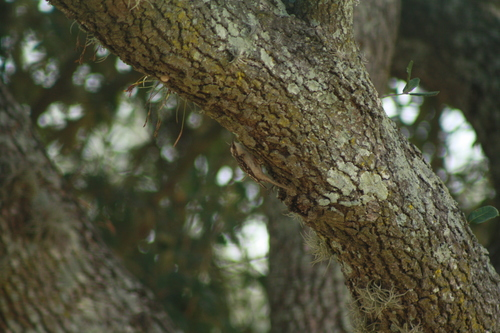

In [ ]:
Detectionfails2 = no_detect
for k,img_paths in Detectionfails2.items():
  if len(img_paths)==0: continue
  print("Dataset:",k)
  for img in img_paths:
    image = cv2.imread(f"{img}")
    cv2_imshow(image)
    _,category = os.path.split(os.path.split(img)[0])
    
    if not square_crop: name_root = '/content/cropped_bird_dataset_no_square'
    else: name_root = '/content/cropped_bird_dataset'
    #print(f"{name_root}/{k}/{category}/{os.path.split(img)[1]}")
    #cv2.imwrite(f"{name_root}/{k}/{category}/{os.path.split(img)[1]}", image)
    # MUST crop it manually or use the full image


In [ ]:
# to save new dataset
#zip_dataset(squared = False)
#download_dataset(squared = square_crop)

In [ ]:
#Detectionfails2 = {'test_images': ['/content/bird_dataset/test_images/mistery_category/8ede0bc5a4976385dcfe6e38feaf90c2.jpg'],
# 'train_images': [],
# 'val_images': []}

# Method 

## 1. Model

In [3]:
#images
import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image

#other
import os, os.path
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

#torch/torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from torchvision.utils import make_grid

#vision transformer
#!pip install --upgrade pytorch-pretrained-vit
from pytorch_pretrained_vit import ViT

In [ ]:
nclasses = 20

class Net(nn.Module):
    def __init__(self, hidden_dim):
        super(Net, self).__init__()
        model_name = 'B_16_imagenet1k'
        self.vit = ViT(model_name, pretrained=True)
        for param in self.vit.parameters():
          param.requires_grad = False
        self.vit.fc = nn.Linear(768, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, nclasses)

    def forward(self, x):
        x = F.relu(self.vit(x))
        x = self.fc1(x)
        return x

In [4]:
seed = 1
torch.manual_seed(seed)

## 2. Data Augmentation and Data Loading

In [ ]:
#rm -r experiment/
if not os.path.isdir('./experiment'):
    os.makedirs('./experiment')

In [ ]:
#!unzip /content/cropped_bird_dataset_no_square.zip
print("==============")
#!unzip /content/cropped_bird_dataset.zip
print("Done")

Done


In [ ]:
# data augmentation

val_trans = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_trans = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [ ]:
batch_size = 16
log_interval = 10
Balanced_data = True 
root = 'content/cropped_bird_dataset_no_square' #'cropped_bird_dataset', #cropped_bird_dataset_no_square

In [ ]:
#data transformation with balanced dataset
if Balanced_data:
  print("Balanced data")
  data  = torch.utils.data.ConcatDataset([datasets.ImageFolder(f'{root}/train_images',transform=None),
                          datasets.ImageFolder(f'{root}/val_images', transform=None)])

  train_len = int(0.9*len(data))
  sub_train_data, sub_val_data = torch.utils.data.random_split(data,[train_len, len(data)-train_len],generator=torch.Generator().manual_seed(42))

  class TransformData(Dataset): #apply the transformations
      def __init__(self, subset, transform):
          self.subset = subset
          self.transform = transform
          
      def __getitem__(self, index):
          x, y = self.subset[index]
          x = self.transform(x)
          return x, y
          
      def __len__(self):
          return len(self.subset)

  train_data = TransformData(sub_train_data, transform=train_trans)
  val_data = TransformData(sub_val_data, transform=val_trans)

  train_loader = torch.utils.data.DataLoader(train_data,
      batch_size=batch_size, shuffle=True, num_workers=1)

  val_loader = torch.utils.data.DataLoader(val_data,
      batch_size=batch_size, shuffle=False, num_workers=1)

else:
  train_loader = torch.utils.data.DataLoader(
      datasets.ImageFolder(f'{root}/train_images',transform=train_trans),
      batch_size=batch_size, shuffle=True, num_workers=1)
  val_loader = torch.utils.data.DataLoader(
      datasets.ImageFolder(f'{root}/val_images',transform=val_trans),
      batch_size=batch_size, shuffle=False, num_workers=1)

In [ ]:
print("Length of train_loader: ", len(train_loader))
print("Length of train_dataset: ", len(train_loader.dataset))
print()
print("Length of val_loader: ", len(val_loader))
print("Length of val_dataset: ", len(val_loader.dataset))
print()
print("Total images:", len(val_loader.dataset)+ len(train_loader.dataset))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


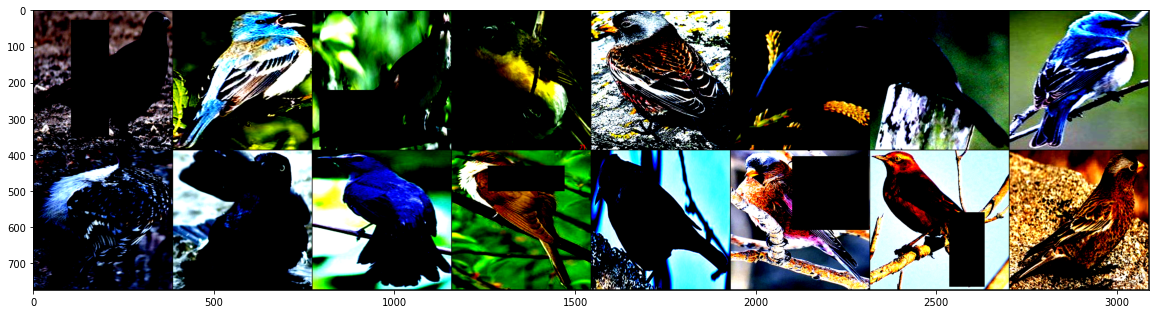

In [ ]:
img, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))
plt.imshow(make_grid(img[:16],ncol=2).permute(1,2,0))
plt.show()

## 3. Optimize hyperparameters

In [ ]:
#!pip install ax-platform

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

In [ ]:
#inspired by https://towardsdatascience.com/quick-tutorial-using-bayesian-optimization-to-tune-your-hyperparameters-in-pytorch-e9f74fc133c2
def train(model, train_loader, parameters, dtype, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9),
                        weight_decay=parameters.get("weight_decay", 3e-4))


    num_epochs = parameters.get("num_epochs", 3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
      model.train()
      for batch_idx, (data, target) in enumerate(train_loader):
          data,target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % log_interval == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.data.item()))
      scheduler.step()
    return model


def train_evaluate(parameterization):

    # Get neural net
    untrained_net = Net(hidden_dim=512) 
    
    # train
    trained_net = train(model=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=val_loader,
        dtype=dtype,
        device=device,
    )

In [ ]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "weight_decay", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        #{"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
        {"name": "hidden", "type": "range", "bounds": [200, 1024]},
        #{"name": "max_epoch", "type": "range", "bounds": [1, 30]},
        #{"name": "stepsize", "type": "range", "bounds": [20, 40]},        
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 11-23 13:47:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-23 13:47:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter weight_decay. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-23 13:47:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-23 13:47:55] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter hidden. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter 

Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.062879
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.989000
Train Epoch: 0 [320/1082 (29%)]	Loss: 3.003329
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.837395
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.826357
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.603678
Train Epoch: 0 [960/1082 (88%)]	Loss: 2.502084
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.405349
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.190740
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.962059
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.840285
Train Epoch: 1 [640/1082 (59%)]	Loss: 1.874671
Train Epoch: 1 [800/1082 (74%)]	Loss: 1.587292
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.416313
Train Epoch: 2 [0/1082 (0%)]	Loss: 1.177483
Train Epoch: 2 [160/1082 (15%)]	Loss: 1.053149
Train Epoch: 2 [320/1082 (29%)]	Loss: 1.205174
Train Epoch: 2 [480/1082 (44%)]	Loss: 1.160785
Train Epoch: 2 [640/1082 (59%)]	Loss: 1.069259
Train Epoch: 2 [800/1082 (74%)]	Loss: 1.073518
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.89

[INFO 11-23 13:51:23] ax.service.managed_loop: Running optimization trial 2...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.955011
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.137366
Train Epoch: 0 [320/1082 (29%)]	Loss: 0.993811
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.512581
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.838255
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.002170
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.285723
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.480696
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.473000
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.157753
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.031706
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.905482
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.092337
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.131792
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.322974
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.182691
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.325579
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.151552
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.440307
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.588479
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.16

[INFO 11-23 13:54:56] ax.service.managed_loop: Running optimization trial 3...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.088640
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.955880
Train Epoch: 0 [320/1082 (29%)]	Loss: 3.059245
Train Epoch: 0 [480/1082 (44%)]	Loss: 3.020825
Train Epoch: 0 [640/1082 (59%)]	Loss: 3.151484
Train Epoch: 0 [800/1082 (74%)]	Loss: 3.045667
Train Epoch: 0 [960/1082 (88%)]	Loss: 3.004508
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.999114
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.913610
Train Epoch: 1 [320/1082 (29%)]	Loss: 2.965177
Train Epoch: 1 [480/1082 (44%)]	Loss: 3.011597
Train Epoch: 1 [640/1082 (59%)]	Loss: 2.959491
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.981925
Train Epoch: 1 [960/1082 (88%)]	Loss: 2.987157
Train Epoch: 2 [0/1082 (0%)]	Loss: 2.933388
Train Epoch: 2 [160/1082 (15%)]	Loss: 3.018352
Train Epoch: 2 [320/1082 (29%)]	Loss: 2.970973
Train Epoch: 2 [480/1082 (44%)]	Loss: 2.978492
Train Epoch: 2 [640/1082 (59%)]	Loss: 2.965662
Train Epoch: 2 [800/1082 (74%)]	Loss: 3.042348
Train Epoch: 2 [960/1082 (88%)]	Loss: 3.05

[INFO 11-23 13:58:41] ax.service.managed_loop: Running optimization trial 4...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.024496
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.969260
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.926051
Train Epoch: 0 [480/1082 (44%)]	Loss: 3.086160
Train Epoch: 0 [640/1082 (59%)]	Loss: 3.004943
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.945311
Train Epoch: 0 [960/1082 (88%)]	Loss: 2.992569
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.845980
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.936281
Train Epoch: 1 [320/1082 (29%)]	Loss: 2.868684
Train Epoch: 1 [480/1082 (44%)]	Loss: 2.778177
Train Epoch: 1 [640/1082 (59%)]	Loss: 2.835130
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.905481
Train Epoch: 1 [960/1082 (88%)]	Loss: 2.879194
Train Epoch: 2 [0/1082 (0%)]	Loss: 2.699944
Train Epoch: 2 [160/1082 (15%)]	Loss: 2.881999
Train Epoch: 2 [320/1082 (29%)]	Loss: 2.803727
Train Epoch: 2 [480/1082 (44%)]	Loss: 2.896074
Train Epoch: 2 [640/1082 (59%)]	Loss: 2.814836
Train Epoch: 2 [800/1082 (74%)]	Loss: 2.840686
Train Epoch: 2 [960/1082 (88%)]	Loss: 2.80

[INFO 11-23 14:02:32] ax.service.managed_loop: Running optimization trial 5...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.076257
Train Epoch: 0 [160/1082 (15%)]	Loss: 3.056017
Train Epoch: 0 [320/1082 (29%)]	Loss: 3.040529
Train Epoch: 0 [480/1082 (44%)]	Loss: 3.057564
Train Epoch: 0 [640/1082 (59%)]	Loss: 3.008942
Train Epoch: 0 [800/1082 (74%)]	Loss: 3.024546
Train Epoch: 0 [960/1082 (88%)]	Loss: 3.007462
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.968565
Train Epoch: 1 [160/1082 (15%)]	Loss: 3.049969
Train Epoch: 1 [320/1082 (29%)]	Loss: 3.031975
Train Epoch: 1 [480/1082 (44%)]	Loss: 3.026352
Train Epoch: 1 [640/1082 (59%)]	Loss: 3.024495
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.965284
Train Epoch: 1 [960/1082 (88%)]	Loss: 2.945613
Train Epoch: 2 [0/1082 (0%)]	Loss: 2.967153
Train Epoch: 2 [160/1082 (15%)]	Loss: 2.931719
Train Epoch: 2 [320/1082 (29%)]	Loss: 2.985986
Train Epoch: 2 [480/1082 (44%)]	Loss: 2.995785
Train Epoch: 2 [640/1082 (59%)]	Loss: 2.864304
Train Epoch: 2 [800/1082 (74%)]	Loss: 2.933414
Train Epoch: 2 [960/1082 (88%)]	Loss: 3.00

[INFO 11-23 14:06:27] ax.service.managed_loop: Running optimization trial 6...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.006871
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.961459
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.668254
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.589248
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.320592
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.005539
Train Epoch: 0 [960/1082 (88%)]	Loss: 2.026365
Train Epoch: 1 [0/1082 (0%)]	Loss: 1.848953
Train Epoch: 1 [160/1082 (15%)]	Loss: 1.638750
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.607127
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.294098
Train Epoch: 1 [640/1082 (59%)]	Loss: 1.325424
Train Epoch: 1 [800/1082 (74%)]	Loss: 1.531862
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.204849
Train Epoch: 2 [0/1082 (0%)]	Loss: 1.290414
Train Epoch: 2 [160/1082 (15%)]	Loss: 1.013681
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.895935
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.903056
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.889443
Train Epoch: 2 [800/1082 (74%)]	Loss: 1.012820
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.78

[INFO 11-23 14:10:21] ax.service.managed_loop: Running optimization trial 7...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.025316
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.952955
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.780105
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.671992
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.709888
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.551279
Train Epoch: 0 [960/1082 (88%)]	Loss: 2.553290
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.510652
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.392930
Train Epoch: 1 [320/1082 (29%)]	Loss: 2.234651
Train Epoch: 1 [480/1082 (44%)]	Loss: 2.204329
Train Epoch: 1 [640/1082 (59%)]	Loss: 2.182387
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.269692
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.842152
Train Epoch: 2 [0/1082 (0%)]	Loss: 2.035595
Train Epoch: 2 [160/1082 (15%)]	Loss: 2.075090
Train Epoch: 2 [320/1082 (29%)]	Loss: 1.912642
Train Epoch: 2 [480/1082 (44%)]	Loss: 1.876289
Train Epoch: 2 [640/1082 (59%)]	Loss: 1.805240
Train Epoch: 2 [800/1082 (74%)]	Loss: 1.782564
Train Epoch: 2 [960/1082 (88%)]	Loss: 1.97

[INFO 11-23 14:14:18] ax.service.managed_loop: Running optimization trial 8...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.008925
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.451831
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.880995
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.031919
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.098678
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.941751
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.611012
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.797419
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.354922
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.528426
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.599872
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.309170
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.431713
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.189735
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.360219
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.309394
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.440445
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.392861
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.325702
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.327850
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.27

[INFO 11-23 14:18:15] ax.service.managed_loop: Running optimization trial 9...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.030048
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.517644
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.089684
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.138169
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.286809
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.828893
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.707373
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.698245
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.405499
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.591636
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.386090
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.575859
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.509390
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.402789
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.526867
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.187332
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.371993
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.306424
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.215998
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.466536
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.43

[INFO 11-23 14:22:15] ax.service.managed_loop: Running optimization trial 10...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.002508
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.606189
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.807501
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.193864
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.087078
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.718198
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.484230
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.650288
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.788304
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.594529
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.263336
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.433725
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.571502
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.395192
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.265049
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.461345
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.371366
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.625271
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.215566
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.429484
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.42

[INFO 11-23 14:26:15] ax.service.managed_loop: Running optimization trial 11...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.974339
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.859827
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.599507
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.195693
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.041493
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.985919
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.473471
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.389962
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.271085
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.493608
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.208341
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.177199
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.191576
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.067618
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.764183
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.571295
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.794142
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.538025
Train Epoch: 2 [640/1082 (59%)]	Loss: 1.138861
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.363362
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.39

[INFO 11-23 14:30:17] ax.service.managed_loop: Running optimization trial 12...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.926639
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.960422
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.890463
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.864552
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.689558
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.588367
Train Epoch: 0 [960/1082 (88%)]	Loss: 2.475517
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.249880
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.081955
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.871823
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.532912
Train Epoch: 1 [640/1082 (59%)]	Loss: 1.470931
Train Epoch: 1 [800/1082 (74%)]	Loss: 1.341510
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.263487
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.963618
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.925457
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.862272
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.672565
Train Epoch: 2 [640/1082 (59%)]	Loss: 1.018976
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.405691
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.36

[INFO 11-23 14:34:19] ax.service.managed_loop: Running optimization trial 13...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.028188
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.972231
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.596588
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.857331
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.465496
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.836019
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.749621
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.677567
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.584204
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.571695
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.420890
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.251171
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.395119
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.091437
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.280423
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.294277
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.124880
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.333064
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.354829
Train Epoch: 2 [800/1082 (74%)]	Loss: 1.319772
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.31

[INFO 11-23 14:38:18] ax.service.managed_loop: Running optimization trial 14...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.077768
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.873421
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.323546
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.085345
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.382610
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.172638
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.683425
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.443362
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.751457
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.486238
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.359723
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.311085
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.620149
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.534647
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.501672
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.559118
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.552771
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.249680
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.283044
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.425272
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.38

[INFO 11-23 14:42:19] ax.service.managed_loop: Running optimization trial 15...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.962653
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.485213
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.023079
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.395686
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.188664
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.944882
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.752829
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.500328
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.514800
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.514576
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.296119
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.357989
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.844074
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.373719
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.328715
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.351479
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.239539
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.543675
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.420987
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.346041
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.28

[INFO 11-23 14:46:21] ax.service.managed_loop: Running optimization trial 16...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.939758
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.605518
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.752599
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.966175
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.424304
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.965733
Train Epoch: 0 [960/1082 (88%)]	Loss: 1.061209
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.922084
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.519974
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.808544
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.645356
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.409277
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.349903
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.568280
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.373673
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.426233
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.598133
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.450390
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.614139
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.350417
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.30

[INFO 11-23 14:50:27] ax.service.managed_loop: Running optimization trial 17...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.007880
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.838115
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.736716
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.552489
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.459803
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.214856
Train Epoch: 0 [960/1082 (88%)]	Loss: 2.248590
Train Epoch: 1 [0/1082 (0%)]	Loss: 1.931406
Train Epoch: 1 [160/1082 (15%)]	Loss: 1.732740
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.701065
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.703322
Train Epoch: 1 [640/1082 (59%)]	Loss: 1.359196
Train Epoch: 1 [800/1082 (74%)]	Loss: 1.474806
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.268952
Train Epoch: 2 [0/1082 (0%)]	Loss: 1.281184
Train Epoch: 2 [160/1082 (15%)]	Loss: 1.302999
Train Epoch: 2 [320/1082 (29%)]	Loss: 1.408317
Train Epoch: 2 [480/1082 (44%)]	Loss: 1.022674
Train Epoch: 2 [640/1082 (59%)]	Loss: 1.020442
Train Epoch: 2 [800/1082 (74%)]	Loss: 1.103088
Train Epoch: 2 [960/1082 (88%)]	Loss: 1.23

[INFO 11-23 14:54:32] ax.service.managed_loop: Running optimization trial 18...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.004834
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.366304
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.852171
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.848189
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.196800
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.571367
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.575445
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.637136
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.608199
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.538896
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.490977
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.659914
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.361744
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.343526
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.377791
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.282793
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.285098
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.325545
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.277744
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.252407
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.54

[INFO 11-23 14:58:35] ax.service.managed_loop: Running optimization trial 19...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.161285
Train Epoch: 0 [160/1082 (15%)]	Loss: 1.621848
Train Epoch: 0 [320/1082 (29%)]	Loss: 0.919222
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.116345
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.513458
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.351001
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.022816
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.210831
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.187291
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.290403
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.177934
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.335496
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.241689
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.064851
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.260679
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.258942
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.016293
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.250587
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.119681
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.141615
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.43

[INFO 11-23 15:02:36] ax.service.managed_loop: Running optimization trial 20...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.923070
Train Epoch: 0 [160/1082 (15%)]	Loss: 1.126351
Train Epoch: 0 [320/1082 (29%)]	Loss: 0.715254
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.028328
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.379752
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.406312
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.492075
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.571761
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.299368
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.551728
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.395847
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.375987
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.048764
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.823855
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.247306
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.151625
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.242632
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.189221
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.015637
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.201560
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.07

## 4. Train and Eval

In [ ]:
#unbalanced data 
lr =  0.06541550081726763
weight_decay = 3.5302970363388805e-05
momentum = 0.20774549631242367
log_interval = 10
hidden = 512

In [ ]:
#balanced data
#lr =  0.08498079844394535
#weight_decay = 3.674781601589462e-05
#momentum = 0.19302944614946424
#log_interval = 10
#hidden = 604

In [ ]:
from pytorch_pretrained_vit import ViT

torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net(hidden_dim=hidden)
model.to(device)
print(device)

Loaded pretrained weights.
cuda:0


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), # or any optimizer you prefer 
                    lr=lr, # 0.001 is used if no lr is specified
                    momentum=momentum,
                    weight_decay=weight_decay)


epochs = 30
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
def train(model, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data,target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    scheduler.step()

def validation(model):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    

In [ ]:
print("Started training")
for epoch in range(1, epochs + 1):
    train(model, epoch)
    validation(model)
    model_file = 'D:\experiment' + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    #print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

Started training
Train Epoch: 1 [0/1082 (0%)]	Loss: 3.040590
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.470191
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.949114
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.217162
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.936565
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.729361
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.744785

Validation set: Average loss: 0.0392, Accuracy: 86/103 (83%)
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.601848
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.736734
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.803055
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.454448
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.193055
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.335544
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.159712

Validation set: Average loss: 0.0263, Accuracy: 86/103 (83%)
Train Epoch: 3 [0/1082 (0%)]	Loss: 0.322054
Train Epoch: 3 [160/1082 (15%)]	Loss: 0.413585
Train Epoch: 3 [320/1082 (29%)]	Loss: 0.237294
Train Epoch: 3 [480/1082 (44%)]	Loss: 0.122925
Train Epoch: 3 [640/10

In [ ]:
#evaluate.py
outfile = 'kaggle7.cvs'
state_dict = torch.load('./model_13.pth')
model.load_state_dict(state_dict)
_ = model.eval()

## 5. Test

In [ ]:
test_dir = 'content/cropped_bird_dataset_no_square/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = val_trans(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = data.to(device)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')
        

100%|████████████████████████████████████████████████████████████████████████████████| 518/518 [00:34<00:00, 15.12it/s]

Succesfully wrote kaggle_unbalanced_17.cvs, you can upload this file to the kaggle competition website


In [ ]:
#import pandas as pd
#data_file92 = pd.read_csv('./kaggle_unbalanced_15.cvs')
#data_file92b = pd.read_csv('./kaggle_unbalanced_17.cvs')
#data_file11 = pd.read_csv('./kaggle_balanced.cvs')

# 🐣